# Privacy-Preserving Detection of COVID-19 in X-Ray Images (DP-SGD)

###### Notebook settings

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [2]:
!pip install tensorflow-privacy

##### Import libraries

In [3]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from tensorflow_privacy.privacy.analysis.compute_noise_from_budget_lib import compute_noise
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasAdamOptimizer

import keras
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

##### Download dataset

##### Define constants

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Model parameters
BATCH_SIZE = 16 # TODO test with 32
IMG_SHAPE = [28, 28, 1] # dataset image size is 299x299
EPOCHS = 20

# DP-SGD parameters
NOISE_MULTIPLIER = 0.638
L2_NORM_CLIP = 1.0
MICROBATCHES = BATCH_SIZE

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data


### Load dataset

In [5]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [6]:
TRAIN_IMG_COUNT = ds_info.splits['train'].num_examples
TEST_IMG_COUNT = ds_info.splits['test'].num_examples
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 60000, Test: 10000


### Prepare for training

###### Define preprocessing and data augmentation

In [7]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

In [8]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [9]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [10]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [11]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [12]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=False,
                                cache='./data.tfcache')
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [13]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1, # TODO batching needed?
                                augment=False)

y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    y_test_attack.append(y)

### Visualization

###### Images from a training batch

In [14]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(5,5))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(np.squeeze(image_batch[n], axis=2), cmap='gray')
        plt.axis("off")

In [15]:
image_batch, label_batch = next(iter(train_batched))

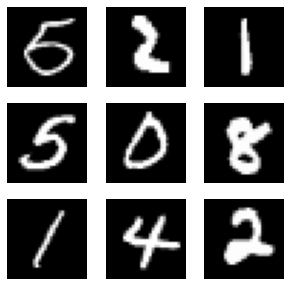

In [16]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Learning rate decay

In [17]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - CNN Archecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [18]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='same', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='same', activation='tanh'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='tanh'),
        BatchNormalization(),
        Dense(units=10, activation='softmax'),
    ])
    return dpnet

In [19]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
]

dpnet.compile(  
    optimizer=VectorizedDPKerasAdamOptimizer(
        l2_norm_clip=L2_NORM_CLIP,
        noise_multiplier=NOISE_MULTIPLIER,
        num_microbatches=MICROBATCHES,
        learning_rate=1e-3 # default: 1e-3
    ),
    loss=SparseCategoricalCrossentropy(
        from_logits=True,
        reduction=tf.compat.v1.losses.Reduction.NONE
        # reduction is set to NONE to get loss in a vector form
    ),
    metrics=METRICS
)

In [20]:
dpnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 32)          8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 32)          128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

### Training

In [21]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[learning_rate_decay],
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4895: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


3750/3750 [==============================] - 55s 6ms/step - loss: 1.3239 - accuracy: 0.5700
Epoch 2/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.5493 - accuracy: 0.8313
Epoch 3/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4579 - accuracy: 0.8651
Epoch 4/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4331 - accuracy: 0.8778
Epoch 5/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4315 - accuracy: 0.8844
Epoch 6/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4331 - accuracy: 0.8869
Epoch 7/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4402 - accuracy: 0.8899
Epoch 8/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4115 - accuracy: 0.8969
Epoch 9/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.4061 - accuracy: 0.8994
Epoch 10/20
3750/3750 [==============================] - 22s 6ms/step - loss: 0.3948

### Evaluation

###### Visualize performance

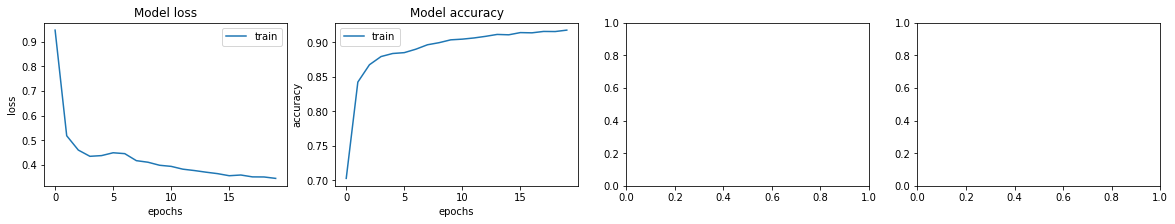

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

In [25]:
loss, acc = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")

625/625 [==============================] - 1s 2ms/step - loss: 0.2945 - accuracy: 0.9305
Loss of the model is -  0.29449281096458435
Accuracy of the model is -  93.04999709129333 %


## Privacy

### Compute epsilon

In [26]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-5

In [27]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [28]:
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-05, Epsilon = 2.004


In [29]:
# get needed noise for target epsilon
min_noise = 1e-5
target_epsilon = 2.0
compute_noise(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    target_epsilon,
    EPOCHS,
    DELTA,
    min_noise
)

DP-SGD with sampling rate = 0.0267% and noise_multiplier = 0.6385325816285611 iterated over 75000 steps satisfies differential privacy with eps = 2 and delta = 1e-05.


0.6385325816285611

### Attacks

###### Model Inversion Attack

In [30]:
!pip install -q adversarial-robustness-toolbox
from art.attacks.inference import model_inversion 
from art.estimators.classification import TensorFlowV2Classifier

     |████████████████████████████████| 983kB 2.8MB/s 
     |████████████████████████████████| 3.4MB 18.4MB/s 
     |████████████████████████████████| 25.3MB 1.5MB/s 


In [31]:
def perform_inversion(classifier, init='white', max_iter=10000, lr=0.1, pred_cutoff=1.0, average_data=None, nb_classes=1):
    # create inversion attack
    attack = model_inversion.MIFace(classifier,
                                    max_iter=max_iter,
                                    threshold=pred_cutoff,
                                    learning_rate=lr)
    
    # init inference image
    if init == 'white':
        x_init = np.ones((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'black':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'grey':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])) + 0.5
    elif init == 'random':
        x_init = np.random.uniform(0, 1, (IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    elif init == 'average':
        x_init = np.zeros((IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])) + np.mean(average_data, axis=0)

    y = np.arange(nb_classes)

    # plot initial image
    plt.imshow(np.squeeze(x_init, axis=2), cmap='gray')
    plt.axis('off')
    plt.title('Initial '+init+' inversion image')
    plt.show()
    print("Prediction - %a" % (classifier.predict(np.expand_dims(x_init, axis=0), training_mode=False)))

    x_init_batch = np.array([x_init for i in range(nb_classes)])

    # ensure that the classifier's gradients are non-vanishing for each target class
    # attack won't work if the classifier's gradients are vanishin
    class_gradient = classifier.class_gradient(x_init_batch, y)
    class_gradient = np.reshape(class_gradient, (nb_classes, IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2]))
    class_gradient_max = np.max(class_gradient, axis=1)

    print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

    # run the attack
    x_infer = attack.infer(x_init_batch, y)
    
    # plot inferred images
    def show_inferred(image_batch):
        plt.figure(figsize=(15,15))
        for n in range(10):
            ax = plt.subplot(2, 5, n+1)
            plt.imshow(np.squeeze(image_batch[n], axis=2), cmap='gray')
            plt.axis("off")
        plt.show()

    print('Final '+init+' inversion images')
    show_inferred(x_infer)
    #print("Prediction - %.4f" % (classifier.predict(np.expand_dims(img, axis=0), training_mode=False))[0][i])

In [32]:
# create classifier for attacks
art_classifier = TensorFlowV2Classifier(model=dpnet,
                                        nb_classes=10,
                                        input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]),
                                        loss_object=SparseCategoricalCrossentropy(),
                                        clip_values=(0, 1))

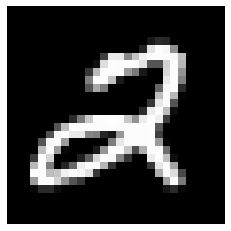

Prediction - array([[1.4019175e-04, 4.1304224e-06, 9.9961579e-01, 1.1556151e-05,
        8.2540595e-08, 2.0061317e-07, 1.2948818e-05, 3.8584326e-07,
        2.1449655e-04, 2.1511158e-07]], dtype=float32)


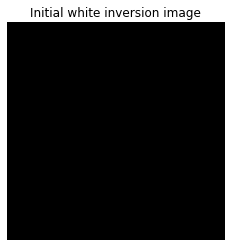

Prediction - array([[4.4164870e-05, 1.9988411e-05, 9.6028625e-06, 4.3903077e-05,
        9.9556988e-01, 9.5118594e-04, 6.0598296e-04, 7.4375589e-07,
        2.7305004e-03, 2.4105038e-05]], dtype=float32)


Minimum over all maximum class gradient: 0.000001



Final white inversion images


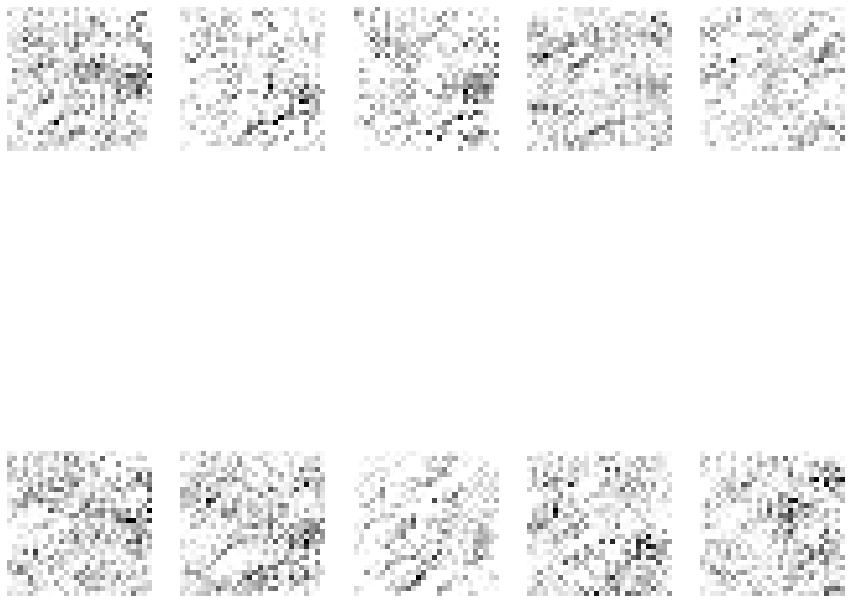

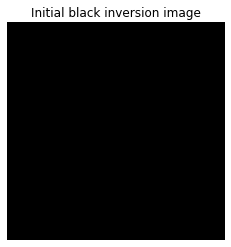

Prediction - array([[1.37147599e-05, 7.50055254e-01, 1.22940055e-05, 1.89989657e-06,
        1.66977569e-01, 4.20885699e-05, 1.39051372e-06, 8.28850120e-02,
        1.08692711e-06, 9.71216105e-06]], dtype=float32)
Minimum over all maximum class gradient: 0.000004



Final black inversion images


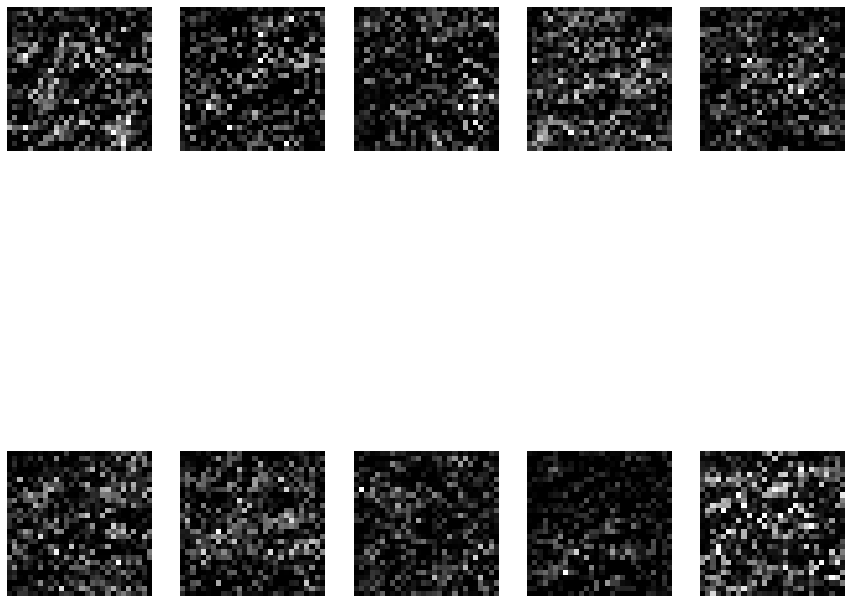

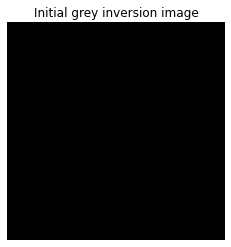

Prediction - array([[1.5569078e-03, 3.0593848e-05, 2.8659834e-04, 8.5202017e-05,
        9.7517812e-01, 1.6927058e-03, 3.6126627e-03, 1.9484076e-05,
        1.7527528e-02, 1.0178492e-05]], dtype=float32)
Minimum over all maximum class gradient: 0.000022



Final grey inversion images


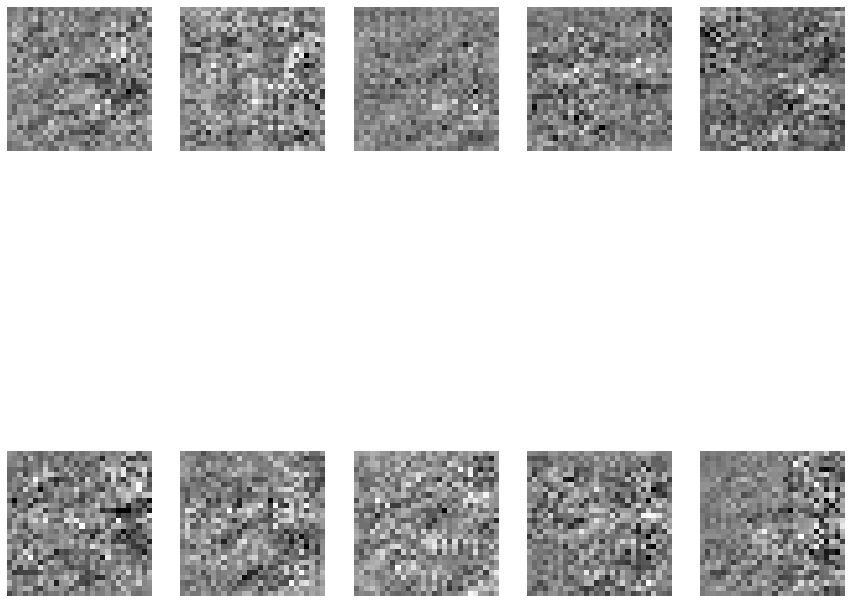

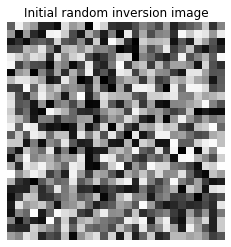

Prediction - array([[1.0348493e-05, 1.0630769e-07, 6.8450777e-06, 6.7741006e-05,
        9.9384528e-01, 6.4690787e-05, 3.0960047e-05, 6.2422791e-05,
        5.8919387e-03, 1.9618634e-05]], dtype=float32)
Minimum over all maximum class gradient: 0.000000



Final random inversion images


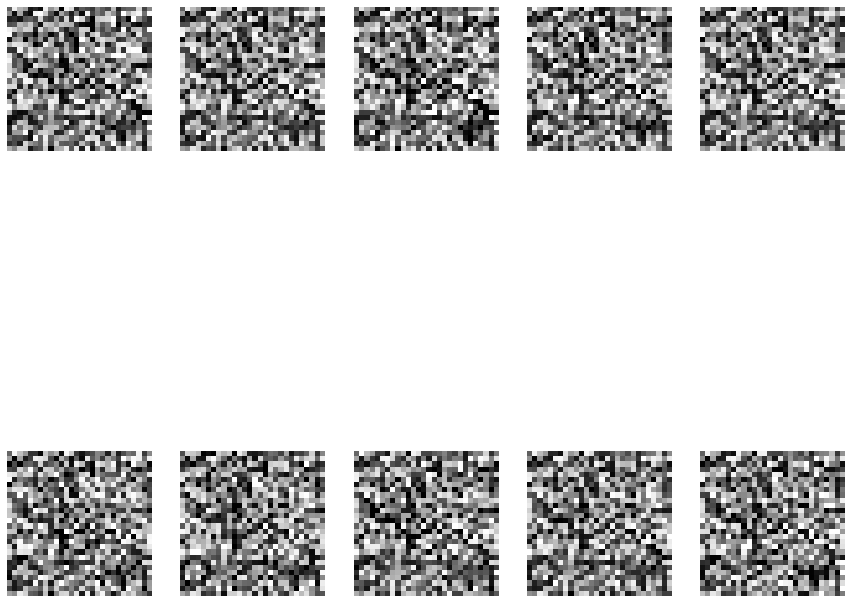

In [34]:
# example original image
image_batch, label_batch = next(iter(x_test_attack))
plt.imshow(np.squeeze(image_batch[0], axis=2), cmap='gray')
plt.axis('off')
plt.show()
print("Prediction - %a" % (art_classifier.predict(image_batch, training_mode=False)))

inits = ['white', 'black', 'grey', 'random']
for init in inits:
    perform_inversion(classifier=art_classifier,
                    init=init,
                    max_iter=1000,
                    lr=1.0,
                    pred_cutoff=1.0,
                    nb_classes=10)